# Wildfire Prediction Project
## Notebook 6) Model 2

After further reflection, it may be ideal to group all the human accident target categories together into one. 

In [1]:
import pandas as pd

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
import warnings
warnings.filterwarnings("ignore")

In [30]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score, balanced_accuracy_score, ConfusionMatrixDisplay, classification_report
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [2]:
df = pd.read_csv("../../data/data_weather.csv", index_col = 0)

In [3]:
df.head(2)

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,...,Wind Gusts (10 m),Soil Temperature (0-7 cm),Soil Temperature (7-28 cm),Soil Moisture (0-7 cm),Soil Moisture (7-28 cm),Maximum Temperature (2 m),Minimum Temperature (2 m),Precipitation Sum,Rain Sum,Snowfall Sum
0,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,30.0,5.0,4.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0
1,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,21.0,17.0,15.0,0.0,0.0,27.0,9.0,0.0,0.0,0.0


#### For the model 2, we will retain the same features
* main difference is reduce the number of target featrues

In [10]:
df_base = df[['FIRE_YEAR', 'DISCOVERY_DOY', 'STAT_CAUSE_DESCR', 'FIRE_SIZE', 'LATITUDE', 'LONGITUDE', 'DISC_MONTH', 
              'DISC_DAY', 'FIRE_DURATION', 'DISC_DAYOFWEEK', 'OWNER_DESCR', 
              'Elevation', 'Temperature (2 m)', 'Wind Gusts (10 m)', 'Soil Temperature (0-7 cm)', 
              'Soil Temperature (7-28 cm)',
              'Maximum Temperature (2 m)', 'Minimum Temperature (2 m)',
              'Precipitation Sum', 'Rain Sum', 'Snowfall Sum']]

In [11]:
df_base.dropna(inplace = True, axis = 0)

### Bin the Target Feature

There are a lot of different classes, let's bin them to just 3 classes. The 3 classes are: natural, accidental, malicious where 
* natural = ['Lightning'] 
* accidental = ['Structure','Fireworks','Powerline','Railroad','Smoking','Children','Campfire','Equipment Use','Debris Burning'] 
* malicious = ['Arson'] 

In [12]:
def set_label(cat):
    cause = 0
    natural = ['Lightning']
    accidental = ['Structure','Fireworks','Powerline','Railroad','Smoking','Children','Campfire','Equipment Use','Debris Burning']
    malicious = ['Arson']
    
    if cat in natural:
        cause = 1
    elif cat in accidental:
        cause = 2
    else:
        cause = 3
    return cause

In [13]:
df_base['LABEL'] = df_base['STAT_CAUSE_DESCR'].apply(lambda x: set_label(x))

In [14]:
df_base.drop('STAT_CAUSE_DESCR',axis=1, inplace = True)

In [15]:
df_base.head(2)

,FIRE_YEAR,DISCOVERY_DOY,FIRE_SIZE,LATITUDE,LONGITUDE,DISC_MONTH,DISC_DAY,FIRE_DURATION,DISC_DAYOFWEEK,OWNER_DESCR,...,Temperature (2 m),Wind Gusts (10 m),Soil Temperature (0-7 cm),Soil Temperature (7-28 cm),Maximum Temperature (2 m),Minimum Temperature (2 m),Precipitation Sum,Rain Sum,Snowfall Sum,LABEL
0,2004,133,0.25,38.933056,-120.404444,5,12,0,2,USFS,...,7.0,30.0,5.0,4.0,15.0,0.0,0.0,0.0,0.0,1
1,2004,152,0.10,38.984167,-120.735556,5,31,0,0,STATE OR PRIVATE,...,19.0,21.0,17.0,15.0,27.0,9.0,0.0,0.0,0.0,2


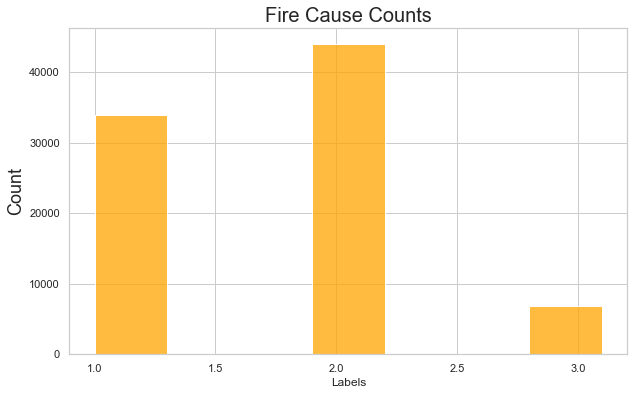

In [27]:
sns.set(style="whitegrid") 
plt.figure(figsize=(10,6))
sns.histplot(data = df_base, x = 'LABEL', color = 'orange', binwidth = 0.3)
plt.title('Fire Cause Counts', size=20)
plt.xlabel('Labels')
plt.ylabel('Count', size=18)
plt.savefig('../../output/figures/FireCauseCounts_3.png', dpi=300)
plt.show()

#### Plot Correlation

<AxesSubplot:>

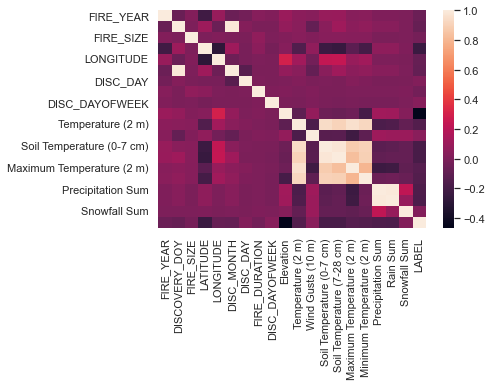

In [28]:
corr = df_base.corr()
sns.heatmap(corr, annot=False)

In [29]:
df_base.shape

(84859, 21)

### Model 2

In [31]:
X = df_base.drop('LABEL', axis = 1)
y = df_base['LABEL']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [33]:
#categorical features
cat_feats = X_train.dtypes[X_train.dtypes == 'object'].index.tolist()
#numeric features
num_feats = X_train.dtypes[~X_train.dtypes.index.isin(cat_feats)].index.tolist()

#### Random Forest

In [34]:
numeric_transform = Pipeline([('FunctionTransformer', FunctionTransformer()), ('impute_mean', SimpleImputer(strategy='mean')),
                              ('scaling', StandardScaler())]
                            )

categorical_transform = Pipeline([('FunctionTransformer',FunctionTransformer()), ('impute_mode', SimpleImputer(strategy='most_frequent')), 
                                  ('one-hot-encode', OneHotEncoder(sparse=False))]
                                )

preprocessing = ColumnTransformer([('numeric', numeric_transform, num_feats), 
                                        ('categorical', categorical_transform, cat_feats)])

pipeline = Pipeline([('preprocessing', preprocessing), ('model', RandomForestClassifier())])

In [36]:
#display pipeline
from sklearn import set_config

set_config(display='diagram')
display(pipeline)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('FunctionTransformer',
                                                                   FunctionTransformer()),
                                                                  ('impute_mean',
                                                                   SimpleImputer()),
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  ['FIRE_YEAR', 'DISCOVERY_DOY',
                                                   'FIRE_SIZE', 'LATITUDE',
                                                   'LONGITUDE', 'DISC_MONTH',
                                                   'DISC_DAY', 'FIRE_DURATION',
                                                   'DISC_DAYOFWEEK',
                                                   'Elevation',
                                                   'Temperature (2 m)...
                                                   'Soil Temperature (7-28 cm)',
                                                   'Maximum Temperature (2 m)',
                                                   'Minimum Temperature (2 m)',
                                                   'Precipitation Sum',
                                                   'Rain Sum',
                                                   'Snowfall Sum']),
                                                 ('categorical',
                                                  Pipeline(steps=[('FunctionTransformer',
                                                                   FunctionTransformer()),
                                                                  ('impute_mode',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one-hot-encode',
                                                                   OneHotEncoder(sparse=False))]),
                                                  ['OWNER_DESCR'])])),
                ('model', RandomForestClassifier())])

In [35]:
pipeline.fit(X_train, y_train)
score = pipeline.score(X_test, y_test)          
print(f'Test set score: {score}')

Test set score: 0.8392646712231911


In [37]:
y_pred = pipeline.predict(X_test)
print(f1_score(y_pred, y_test, average='weighted'), balanced_accuracy_score(y_test, y_pred))

0.856513286256951 0.6641196836536543


In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.88      0.90      0.89      6736
           2       0.82      0.90      0.86      8794
           3       0.73      0.19      0.31      1442

    accuracy                           0.84     16972
   macro avg       0.81      0.66      0.68     16972
weighted avg       0.83      0.84      0.82     16972



In [35]:
from sklearn.model_selection import GridSearchCV

In [30]:
# set up our parameters grid
param_grid = {"model__n_estimators":[100, 120, 140], "model__max_depth":[19, 20, 21]}

# create a Grid Search object
grid_search = GridSearchCV(pipeline, param_grid, n_jobs = -1, verbose=10, refit=True)    

# fit the model and tune parameters
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('FunctionTransformer',
                                                                                          FunctionTransformer()),
                                                                                         ('impute_mean',
                                                                                          SimpleImputer()),
                                                                                         ('scaling',
                                                                                          StandardScaler())]),
                                                                         ['FIRE_YEAR',
                                                                          'DISCOVERY_DOY',
                                                                          'FIRE_SIZE',
                                                                          'LATITUDE',
                                                                          'LONGITUDE',
                                                                          'DISC_MONTH',
                                                                          'DISC_DAY',
                                                                          'FIRE_DURATION',
                                                                          'DISC_DAYOFWEEK',
                                                                          'Elev...
                                                                          'Snowfall '
                                                                          'Sum']),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('FunctionTransformer',
                                                                                          FunctionTransformer()),
                                                                                         ('impute_mode',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('one-hot-encode',
                                                                                          OneHotEncoder(sparse=False))]),
                                                                         ['OWNER_DESCR'])])),
                                       ('model', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'model__max_depth': [19, 20, 21],
                         'model__n_estimators': [100, 120, 140]},
             verbose=10)

In [31]:
print(grid_search.best_params_)

{'model__max_depth': 20, 'model__n_estimators': 140}


In [32]:
pipeline = Pipeline([('preprocessing', preprocessing), ('model', RandomForestClassifier(max_depth=20, n_estimators= 140))])

In [33]:
pipeline.fit(X_train, y_train)
score = pipeline.score(X_test, y_test)          
print(f'Test set score: {score}')

Test set score: 0.6577303794485034


^this did worse than the pre-grid search?

In [ ]:
#Try another algorithm

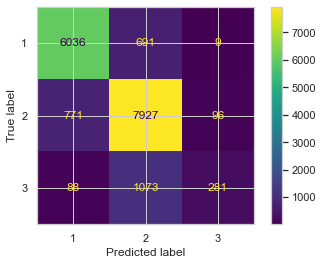

In [39]:
y_pred = pipeline.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

### Save model as pickle to use in App

In [26]:
import pickle

In [31]:
pickle.dump(pipeline, open( "../scripts/model.p", "wb" ))

### Investigate feature importance
- first make a features list accounting for the 'OWNER_DESCR' being one-hot encoded

In [41]:
features = X_train.columns.to_list()
features.pop(9)
features.extend(['PRIVATE', 'USFS', 'BLM', 'MISSING/NOT SPECIFIED',
       'STATE OR PRIVATE', 'COUNTY', 'UNDEFINED FEDERAL', 'STATE', 'FWS',
       'NPS', 'BOR', 'MUNICIPAL/LOCAL', 'TRIBAL', 'OTHER FEDERAL', 'BIA'])

In [42]:
importances = pd.DataFrame(data={
    'Attribute': features,
    'Importance': pipeline.steps[1][1].feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)

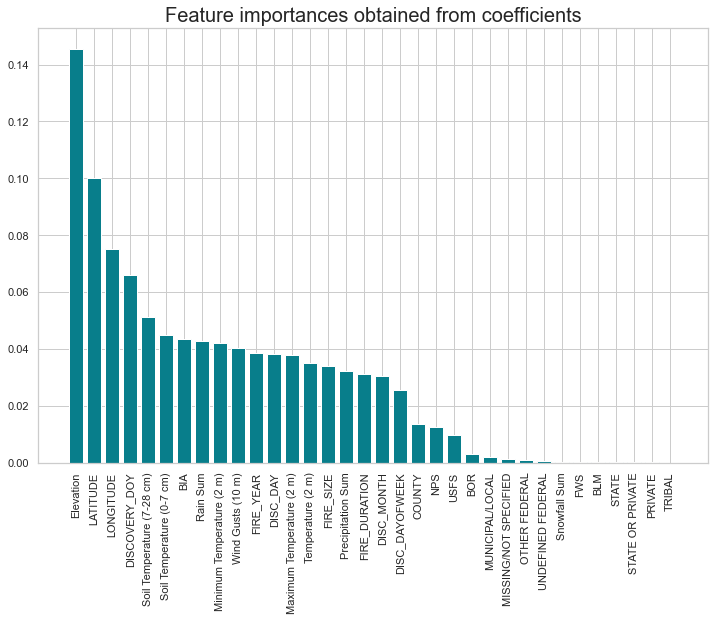

In [63]:
plt.figure(figsize=(12,8))
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.savefig('../../output/figures/FeatureImportance.png', dpi=300)
plt.show()

### Trying different algorithms

#### SVM Algorithm

In [44]:
numeric_transform = Pipeline([('FunctionTransformer', FunctionTransformer()), ('impute_mean', SimpleImputer(strategy='mean')),
                              ('scaling', StandardScaler())])

categorical_transform = Pipeline([('FunctionTransformer', FunctionTransformer()), ('impute_mode', SimpleImputer(strategy='most_frequent')), 
                                  ('one-hot-encode', OneHotEncoder(sparse=False))])

preprocessing = ColumnTransformer([('numeric', numeric_transform, num_feats), 
                                   ('categorical', categorical_transform, cat_feats)])

pipeline1 = Pipeline([('preprocessing', preprocessing), ('model', SVC(gamma='auto'))])

In [45]:
pipeline1.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('FunctionTransformer',
                                                                   FunctionTransformer()),
                                                                  ('impute_mean',
                                                                   SimpleImputer()),
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  ['FIRE_YEAR', 'DISCOVERY_DOY',
                                                   'FIRE_SIZE', 'LATITUDE',
                                                   'LONGITUDE', 'DISC_MONTH',
                                                   'DISC_DAY', 'FIRE_DURATION',
                                                   'DISC_DAYOFWEEK',
                                                   'Elevation',
                                                   'Temperature (2 m)...
                                                   'Soil Temperature (7-28 cm)',
                                                   'Maximum Temperature (2 m)',
                                                   'Minimum Temperature (2 m)',
                                                   'Precipitation Sum',
                                                   'Rain Sum',
                                                   'Snowfall Sum']),
                                                 ('categorical',
                                                  Pipeline(steps=[('FunctionTransformer',
                                                                   FunctionTransformer()),
                                                                  ('impute_mode',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one-hot-encode',
                                                                   OneHotEncoder(sparse=False))]),
                                                  ['OWNER_DESCR'])])),
                ('model', SVC(gamma='auto'))])

In [46]:
score = pipeline1.score(X_test, y_test)          
print(f'Test set score: {score}')

Test set score: 0.7933655432477021


In [47]:
y_pred1 = pipeline1.predict(X_test) 
print(f1_score(y_pred1, y_test, average='weighted'), balanced_accuracy_score(y_test, y_pred1))

0.8283340958670322 0.5763496524928553


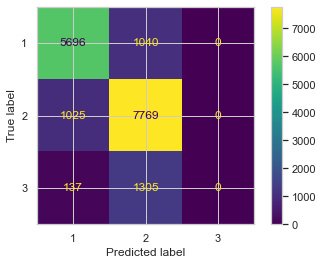

In [48]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred1)

In [49]:
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           1       0.83      0.85      0.84      6736
           2       0.77      0.88      0.82      8794
           3       0.00      0.00      0.00      1442

    accuracy                           0.79     16972
   macro avg       0.53      0.58      0.55     16972
weighted avg       0.73      0.79      0.76     16972



#### XGBoost
Labels must start at 0

In [50]:
from xgboost import XGBClassifier

In [51]:
# start at 0 and convert from float to int
y_train_xg = (y_train - 1).astype('int64')
y_test_xg = (y_test - 1).astype('int64')

In [52]:
numeric_transform = Pipeline([('FunctionTransformer', FunctionTransformer()), ('impute_mean', SimpleImputer(strategy='mean')),
                              ('scaling', StandardScaler())])

categorical_transform = Pipeline([('FunctionTransformer', FunctionTransformer()), ('impute_mode', SimpleImputer(strategy='most_frequent')), 
                                  ('one-hot-encode', OneHotEncoder(sparse=False))])

preprocessing = ColumnTransformer([('numeric', numeric_transform, num_feats), 
                                   ('categorical', categorical_transform, cat_feats)])

pipeline2 = Pipeline([('preprocessing', preprocessing), ('model', XGBClassifier(eval_metric= 'merror'))])

In [53]:
pipeline2.fit(X_train, y_train_xg)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('FunctionTransformer',
                                                                   FunctionTransformer()),
                                                                  ('impute_mean',
                                                                   SimpleImputer()),
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  ['FIRE_YEAR', 'DISCOVERY_DOY',
                                                   'FIRE_SIZE', 'LATITUDE',
                                                   'LONGITUDE', 'DISC_MONTH',
                                                   'DISC_DAY', 'FIRE_DURATION',
                                                   'DISC_DAYOFWEEK',
                                                   'Elevation',
                                                   'Temperature (2 m)...
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=8, num_parallel_tree=1,
                               objective='multi:softprob', predictor='auto',
                               random_state=0, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=None, subsample=1,
                               tree_method='exact', validate_parameters=1,
                               verbosity=None))])

In [54]:
score = pipeline2.score(X_test, y_test_xg)          
print(f'Test set score: {score}')

Test set score: 0.8333726137167099


In [55]:
y_pred2 = pipeline2.predict(X_test) 
print(f1_score(y_pred2, y_test_xg, average='weighted'), balanced_accuracy_score(y_test_xg, y_pred2))

0.8539743824114824 0.6467361784133914


In [56]:
print(classification_report(y_test_xg, y_pred2))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      6736
           1       0.81      0.90      0.85      8794
           2       0.71      0.15      0.24      1442

    accuracy                           0.83     16972
   macro avg       0.80      0.65      0.66     16972
weighted avg       0.83      0.83      0.81     16972



## Results

In [57]:
results = pd.read_csv("../../output/results.csv", index_col = 0)

In [58]:
new_rows = pd.DataFrame({'Model': [2,2,2], 
                                   'Classifier': ['Random Forest', 'SVC', 'XGBoost'], 
                                   'Accuracy': [0.8392646712231911, 0.7933655432477021, 0.8333726137167099], 
                                   'Balanced Score': [0.6641196836536543, 0.5763496524928553, 0.6467361784133914], 
                                   'F1 Score': [0.856513286256951, 0.8283340958670322, 0.8539743824114824]})

In [59]:
results = pd.concat([results, new_rows])

In [60]:
results.reset_index(inplace=True, drop= True)

In [61]:
results

,Model,Classifier,Accuracy,Balanced Score,F1 Score
0,0,Random Forest,0.646740,0.336719,0.675347
1,0,SVC,0.648684,0.204975,0.622821
2,0,XGBoost,0.653513,0.352869,0.681627
3,1,Random Forest,0.659380,0.327566,0.690584
4,1,SVC,0.607000,0.247482,0.666549
5,1,XGBoost,0.666686,0.363703,0.692729
6,2,Random Forest,0.839265,0.664120,0.856513
7,2,SVC,0.793366,0.576350,0.828334
8,2,XGBoost,0.833373,0.646736,0.853974


In [62]:
results.to_csv("../../output/results.csv")